In [1]:
import pydot

In [2]:
import keras
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense, Add
from keras import regularizers
%pylab inline

/gpfs/home/smdick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [161]:
from ase.io import read
from sklearn.model_selection import train_test_split
import numpy as np
from ase import Atoms

class Dataset():
    """
    Dataset that saves the training and test data (split automatically)
    along with the associated atomic species
    """
    
    def __init__(self):
        self.atoms = None
        self.features = {} 
        self.energies = np.zeros([0])
        self.forces = None
        self.X_train = {}
        self.X_test = {}
        self.y_train = 0
        self.y_test = 0
        
    def import_features(self, file, species):
        features = np.genfromtxt(file, delimiter = ',')
        self.set_features(features)
        
    def import_atoms(self, file):
        """
        Import processed features from either .traj, .xyz or .csv file.
        If .csv file is imported additional information has
        to be given in kwargs
        """
        pass
    
    def import_energies(self, file):
        pass
    
    def split(self, test_size=0.2, seed = 42):
        
        for key in self.features:
            
            self.X_train[key], self.X_test[key], self.y_train, self.y_test =\
                train_test_split(self.features[key].reshape(len(self.energies),-1),self.energies, 
                                test_size=0.2, random_state=42)
                
            self.X_train[key] = self.X_train[key].reshape(-1,self.features[key].shape[1])
            self.X_test[key] = self.X_test[key].reshape(-1,self.features[key].shape[1])
            
    def set_features(self, features, species):
        if species in self.features:
            if self.features[species].shape[1] == features.shape[1]:
                self.features[species] = np.concatenate([self.features[species], features])
            else:
                raise Exception('Shape of new features {} inconsistent'.format(features.shape) +\
                                'with features already imported {}'.format(self.features[species].shape))
        else:
            self.features[species] = features
    
    def set_atoms(self, descr_str):
        self.atoms = Atoms(descr_str)
    
    def set_energies(self, energies):
        energies = np.array(energies)
        if energies.ndim != 1 and energies.shape[1] != 1:
            raise Exception('Please provide 1-d array for energies')
        self.energies = np.concatenate([self.energies, energies.flatten()])
      
    def get_atoms(self):
        return self.atoms
    
    def get_features(self, species, which='train'):
        if which=='train':
            return self.X_train[species]
        elif which=='test':
            return self.X_test[species]
        elif which=='all':
            return self.features[species]
        else:
            raise Error('which = '+ which + ' is an invalid option')
            
    def get_energies(self, which = 'train'):
        if which=='train':
            return self.y_train
        elif which=='test':
            return self.y_test
        elif which=='all':
            return self.energies
        else:
            raise Error('which = '+ which + ' is an invalid option')
            

In [170]:
from keras.models import Model
from keras.layers import Input, Dense, Add
from keras import regularizers
from keras.utils import Sequence
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

def get_atoms_per_species(dataset):
    """ 
    Determines how many atom of each species are contained in 
    one sample of a homogeneous dataset
    """
    species = get_unique_species([dataset])
    n_per_species = {}
    
    for s in species:
        n_per_species[s] = np.sum(np.array(dataset.get_atoms().get_chemical_symbols()) == s)
    return n_per_species    
    
def get_unique_species(datasets):
    """ 
    Determines how many unique atomic species are contained in 
    a collection of datasets
    """
    symbols = [] 
    for dataset in datasets:
        symbols.append(np.unique(dataset.get_atoms().get_chemical_symbols()))
    symbols = np.unique(np.concatenate(symbols))

    return symbols


class BatchGenerator(Sequence):
    
    def __init__(self, inputs, outputs, batch_size):
        if not len(inputs) == len(outputs):
            raise Exception('Inputs and outputs list must have same length',
                            'maybe group inputs by datasets')
            
        self.inputs, self.outputs = inputs, outputs
        self.batch_size = batch_size
        self.length = min([int(np.ceil(len(out)/batch_size)) for out in self.outputs])
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        batch_in = []
        batch_out = []
        for inp_dataset in self.inputs:
            for inp_atomic in inp_dataset:
                batch_in.append(inp_atomic[idx * self.batch_size:(idx + 1) * self.batch_size])
       
        for out_dataset in self.outputs:
            batch_out.append(out_dataset[idx * self.batch_size:(idx + 1) * self.batch_size])

        if idx == self.length - 1:
            min_length = min([len(out) for out in batch_out])
            for i,_ in enumerate(batch_in):
                batch_in[i] = batch_in[i][:min_length]
            for i,_ in enumerate(batch_out):
                batch_out[i] = batch_out[i][:min_length]    
        return batch_in, batch_out
            
    def on_epoch_end(self):
        for i, (inp_dataset, out_dataset) in enumerate(zip(self.inputs, self.outputs)):
            *self.inputs[i], self.outputs[i] = shuffle(*inp_dataset, out_dataset)

class Functional():
    
    def __init__(self, datasets):
        pass
            
    def fit(self, *args,**kwargs):
        pass
    
   
        
class EnergyFunctional(Functional):
    
    def __init__(self):
        
        self.defaults = {'layers': 3, 'nodes': 16, 'activations': 'sigmoid','reg' : 0}
        self.target_shape = 1
        self.hidden_layers = {}
        self.scalers = {}
        
        # The model used to fit the datasets
        self.model = None
        
        # (Sub-)Models that are used to treat single atoms of a given species
        self.atomic_models = {}
        
        
    def build_submodel(self, species, input_shape):
        
        inputs = Input(shape = (input_shape,))
        x = inputs
        for hlayer in self.hidden_layers[species]:
            x = hlayer(x)
        outputs = x
    
        return inputs, outputs    
    
    def fit_scalers(self, datasets):
        
        for species in self.species:
            all_feat = []
            for dataset in datasets:
                all_feat.append(dataset.get_features(species, which = 'all'))
            all_feat = np.concatenate(all_feat)
        
            self.scalers[species] = MinMaxScaler()
            self.scalers[species].fit(all_feat)
        
                
    def build_from_datasets(self, datasets):
        
        # Identify unique atomic species
        if not isinstance(datasets, list): 
            datasets = [datasets]
            
        self.datasets = datasets
        self.species = get_unique_species(datasets)
        self.fit_scalers(datasets)
        for dataset in datasets:
            dataset.split()
            
        # Build hidden layers for each species
        for s in self.species:
            self.hidden_layers[s] = []
            for layer in range(self.defaults['layers']):
                self.hidden_layers[s].append(Dense(units=self.defaults['nodes'],
                                           activation=self.defaults['activations'],
                                           kernel_regularizer=regularizers.l2(self.defaults['reg'])))
            
            self.hidden_layers[s].append(Dense(units=self.target_shape,
                                       activation='linear',
                                       kernel_regularizer=regularizers.l2(self.defaults['reg'])))
                
        # Build model
        all_inputs = []
        all_outputs = []
        input_shape_species = {}
        for dataset in datasets:
            inputs = []
            outputs = []
            
            atoms_per_species = get_atoms_per_species(dataset)
            unique_species = get_unique_species([dataset]) 
            
            for species in unique_species:
                input_shape = dataset.get_features(species).shape[1]
                input_shape_species[species] = input_shape
#                 print(atoms_per_species[species])
                for input_n in range(atoms_per_species[species]):
                    in_t, out_t = self.build_submodel(species, input_shape)
                    inputs.append(in_t)
                    outputs.append(out_t)
                
            output = Add()(outputs)
            all_outputs.append(output)
            all_inputs += inputs
       
        self.model = Model(inputs=all_inputs, outputs = all_outputs) 
        
        # Build atomic models
        for species in self.species:
            in_atomic, out_atomic = self.build_submodel(species, input_shape_species[species])
            self.atomic_models[species] = Model(inputs=in_atomic, outputs = out_atomic)
    
    def get_in_out(self):
        
        all_inputs = []
        all_outputs = []
        
        for dataset in self.datasets:
            atoms_per_species = get_atoms_per_species(dataset)
            unique_species = get_unique_species([dataset]) 
            inputs = []
            for species in unique_species:
                for n in range(atoms_per_species[species]):
                    inputs.append(self.scalers[species].transform(\
                            dataset.get_features(species)[n::atoms_per_species[species]]))
                    
            all_inputs.append(inputs)
            all_outputs.append(dataset.get_energies())
        return all_inputs, all_outputs
    
    def fit(self, epochs=10, batch_size=32):
        inputs, outputs = self.get_in_out()
        seq = BatchGenerator(inputs, outputs, batch_size)
        self.model.fit_generator(seq, epochs=epochs, shuffle = False, verbose = 0)

In [171]:
def get_dataset(path, n_mol, n_o_orb=18, n_h_orb=8):
    feat = np.genfromtxt(path + 'descriptors_coeff.dat', delimiter = ',')
    tar  = np.genfromtxt(path + 'energies.dat', delimiter = ',') -\
            np.genfromtxt(path + 'energies_siesta.dat', delimiter = ',') - 469.766523 * n_mol
    dataset = Dataset()
    dataset.set_atoms('{}OHH'.format(n_mol))
    feat = feat.reshape(len(feat)*n_mol, -1)
    dataset.set_features(feat[:,:n_o_orb], 'O')
    dataset.set_features(feat[:,n_o_orb:].reshape(-1,n_h_orb), 'H')
    dataset.set_energies(tar)
    return dataset

In [172]:
basepath = '/gpfs/home/smdick/exchange_ml/data/synced/processed/'
monomers = get_dataset(basepath + 'monomers/final_small/', 1)
dimers = get_dataset(basepath + 'dimers/final/', 2)

In [173]:
func = EnergyFunctional()
func.build_from_datasets([monomers, dimers])

In [174]:
func.model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

In [175]:
func.fit(epochs = 100, batch_size = 300)

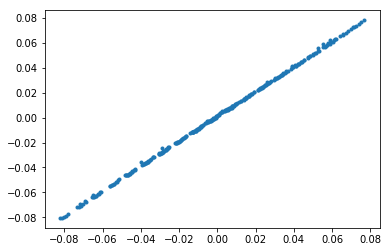

In [138]:
plot(func.model.predict([feat_h1,feat_h2,feat_o]), tar, ls = '', marker = '.')

In [140]:
model_o = func.atomic_models['O']
model_h = func.atomic_models['H']

In [142]:
np.allclose(func.model.predict([feat_h1,feat_h2,feat_o]),
            model_o.predict(feat_o) + model_h.predict(feat_h1) + model_h.predict(feat_h2))

True